In [ ]:
## quick script to see whether it matters if we include taiwan in zonal rainfall averages
#or not.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
%matplotlib notebook
%load_ext autotime
from bootstrap import *
import numpy.ma as ma
from chr_matplotlib import remappedColorMap

In [2]:
ferretpath = "/Users/Siwen/Desktop/ferret/bin/"
ff_notaiwan = "Pchina_type_notaiwan.nc"
ff = "Pchina_type.nc"

filename_notaiwan = ferretpath + ff_notaiwan
filename = ferretpath + ff

myf_notaiwan = nc.Dataset(filename_notaiwan, 'r')
myf = nc.Dataset(filename, 'r')

time: 9.79 ms


In [3]:
P_total_notaiwan =  myf_notaiwan.variables['Pchina_total'][:]
P_band_notaiwan = myf_notaiwan.variables['Pchina_band'][:]
P_local_notaiwan = myf_notaiwan.variables['Pchina_local'][:]

P_total =  myf.variables['Pchina_total'][:]
P_band = myf.variables['Pchina_band'][:]
P_local = myf.variables['Pchina_local'][:]



time: 126 ms


In [4]:
def smooth(P,dayrange,latrange):
    Psmooth=np.zeros(P.shape)
    
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    for d in range(days):
        for j in range(lats):
            
            Psample = P.take(range(d-ll,d+ll+1), mode='wrap', axis=0)
            Ps = Psample[:,max(0,j-yy):min(days,j+yy+1)]
            Psmooth[d,j] = np.mean(np.mean(Ps))
    
    return Psmooth

time: 7.04 ms


In [6]:
#years of interest - start and end date, with index starting at 1 out of habit.
p1_yr_b = [1,30]
p1_yr_e = [29,43]
p2_yr_b = [30,44]
p2_yr_e = [57,57]

P_total_diff = []
P_band_diff = []
P_local_diff = []

P_total_diff_notaiwan = []
P_band_diff_notaiwan = []
P_local_diff_notaiwan = []

#cycle through all time periods of interest and find changes in each type of rainfall b/w periods
for p1_b, p1_e, p2_b, p2_e, i in zip(p1_yr_b, p1_yr_e, p2_yr_b, p2_yr_e, np.arange(len(p1_yr_b))): 
    
    P_total_diff.append(np.mean(P_total[:,:,p2_b-1:p2_e], axis=2) - \
                         np.mean(P_total[:,:,p1_b-1:p1_e], axis=2))
    P_band_diff.append(np.mean(P_band[:,:,p2_b-1:p2_e], axis=2) \
                       - np.mean(P_band[:,:,p1_b-1:p1_e], axis=2))
    P_local_diff.append(np.mean(P_local[:,:,p2_b-1:p2_e], axis=2) \
                        - np.mean(P_local[:,:,p1_b-1:p1_e], axis=2))
    
    P_total_diff_notaiwan.append(np.mean(P_total_notaiwan[:,:,p2_b-1:p2_e], axis=2) - \
                         np.mean(P_total_notaiwan[:,:,p1_b-1:p1_e], axis=2))
    P_band_diff_notaiwan.append(np.mean(P_band_notaiwan[:,:,p2_b-1:p2_e], axis=2) \
                       - np.mean(P_band_notaiwan[:,:,p1_b-1:p1_e], axis=2))
    P_local_diff_notaiwan.append(np.mean(P_local_notaiwan[:,:,p2_b-1:p2_e], axis=2) \
                        - np.mean(P_local_notaiwan[:,:,p1_b-1:p1_e], axis=2))

time: 48.1 ms


In [7]:
## SMOOTHING ##
#smooth out the decadal precipitation means
#but, no latitudinal smoothing since rainfall already effectively smoothed in latitude
daysmth = 15
latsmth = 0

#one line! thank you python!
P_total_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_total_diff ]
P_band_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_band_diff ]
P_local_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_local_diff ]

P_total_diff_notaiwan_smth = [ smooth(x,daysmth,latsmth) for x in P_total_diff_notaiwan ]
P_band_diff_notaiwan_smth = [ smooth(x,daysmth,latsmth) for x in P_band_diff_notaiwan ]
P_local_diff_notaiwan_smth = [ smooth(x,daysmth,latsmth) for x in P_local_diff_notaiwan ]

time: 8.56 s


In [9]:
P_total_delta = [ P1-P2 for P1,P2 in zip(P_total_diff_notaiwan_smth, P_total_diff_smth) ]
P_band_delta = [ P1-P2 for P1,P2 in zip(P_band_diff_notaiwan_smth, P_band_diff_smth) ]
P_local_delta = [ P1-P2 for P1,P2 in zip(P_local_diff_notaiwan_smth, P_local_diff_smth) ]

time: 3.11 ms


<IPython.core.display.Javascript object>


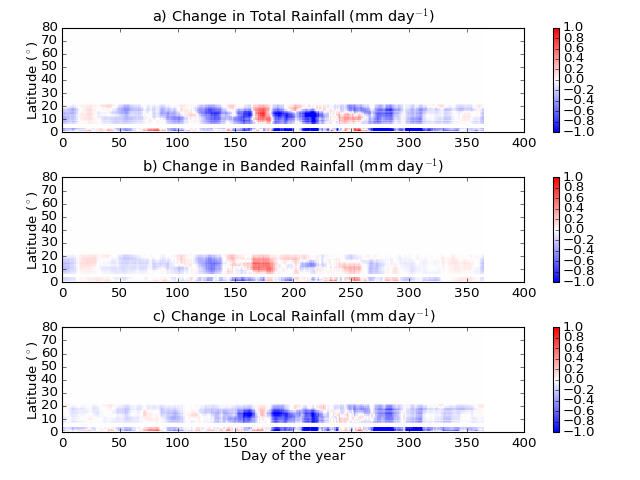

Overwriting existing version of file...
time: 12.7 s


In [23]:
## CREATE FIGURE OF 1951-1979 v 1980-2007 changes

#axlim = max(np.max(abs(P_total_diff_mask[0])),np.max(abs(P_band_diff_mask[0])),np.max(abs(P_local_diff_mask[0])))
mypalette = 'bwr'

fig, ax = plt.subplots()

ax1 = fig.add_subplot(3,1,1)
plot1 = ax1.pcolormesh(P_total_delta[1].T, cmap = mypalette, vmin = -1, vmax = 1); 
ax1.set_title("a) Change in Total Rainfall (mm day$^{-1}$)", fontsize=13)
#plt.xlabel('Day of the year', fontsize=12, labelpad=0)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
cbar1 = fig.colorbar(plot1)

ax2 = fig.add_subplot(3,1,2)
plot2 = ax2.pcolormesh(P_band_delta[1].T, cmap = mypalette, vmin = -1, vmax = 1); 
ax2.set_title("b) Change in Banded Rainfall (mm day$^{-1}$)", fontsize=13)
#plt.xlabel('Day of the year', fontsize=12, labelpad=0)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
cbar2 = fig.colorbar(plot2)


ax3 = fig.add_subplot(3,1,3)
plot3 = ax3.pcolormesh(P_local_delta[1].T, cmap = mypalette, vmin = -1, vmax = 1); 
ax3.set_title("c) Change in Local Rainfall (mm day$^{-1}$)", fontsize=13)
plt.xlabel('Day of the year', fontsize=12, labelpad=0)
plt.ylabel('Latitude ($^\circ$)', fontsize=12, labelpad=0)
cbar3 = fig.colorbar(plot3)


plt.tight_layout(pad=0, w_pad=0, h_pad=.5)
ax.set_axis_off()

savepath = "/Users/Siwen/RDA/chinarain_taiwan_test.pdf"

if os.path.exists(savepath):
    print("Overwriting existing version of file...")
    os.remove(savepath)

plt.savefig(savepath)